In [23]:
import numpy as np
import heapq
from scipy.stats import gamma

class BranchingProcess:
    def __init__(self, T=1.0, alpha=0.2, c = 0.15, d=5, x0=None, kappa=0.5, theta=2.5, n=96000, M=1000):
        self.T = T
        self.alpha = alpha
        self.b = np.linspace(1 + 1 / d, 2, d) / d
        self.c = c
        self.d = d
        self.sigma0 = 1 / np.sqrt(d)
        if x0 is None:
            self.x0 = np.full(d, 0.5)
        else:
            self.x0 = np.array(x0)
        self.kappa = kappa
        self.theta = theta
        self.n = n
        self.M = M
        self.reset()

    def reset(self):
        self.time = 0.0
        self.next_splitting_time = []
        split_time = min(np.random.gamma(shape = self.kappa, scale = self.theta), self.T)
        heapq.heappush(self.next_splitting_time, (split_time, (1,)))
        
        # population dict keeps track of data of all particles
        # key is particle lable, 
        # value is (mark, birth state X_{T_k-}, death state X_{T_k}, birth time T_k-, death time T_k, value of W_k, value of splitting I_k)
        self.population = {(1,): (
            0, 
            self.x0, 
            self.x0 + np.sqrt(split_time)*self.sigma0*np.random.normal(size=self.d), 
            0.0, 
            split_time,
            1.0,
            np.random.binomial(n = 1, p = 0.5)
            )}

    def step(self):
        (tau, label) = heapq.heappop(self.next_splitting_time)
        tau = min(tau, self.T)
        self.time = tau
        if tau >= self.T:
            return
        i = self.population[label][-1]
        if i == 1:
            l1,l2 = label + (1,), label + (2,)
            x = self.population[label][2]
            s1,s2 = np.random.gamma(shape = self.kappa, scale = self.theta, size = 2)
            s1,s2 = min(s1 + tau, self.T), min(s2 + tau,self.T) 
            i1,i2 = np.random.binomial(n = 1, p = 0.5, size = 2) 
            heapq.heappush(self.next_splitting_time, (s1, l1))
            heapq.heappush(self.next_splitting_time, (s2, l2))
            dw1 = np.sqrt(s1 - tau) * np.random.normal(size = self.d)
            self.population[label + (1,)] = (0, x, x + self.sigma0*dw1, tau, s1, 1.0, i1)
            
            dw2 = np.sqrt(s2 - tau)*np.random.normal(size = self.d)
            wbar =  dw2 / ((s2 - tau)*self.sigma0)
            wk = self.b @ wbar 
            self.population[label + (2,)] = (1, x, x + self.sigma0*dw2, tau, s2, wk, i2)                    

    def cl(self,idx,t,x):
        if idx == 0:
            return np.cos(sum(x))*(self.alpha + self.sigma0**2 / 2 + self.c*np.sin(sum(x))*(3 * self.d + 1) / (2 * self.d) * np.exp(self.alpha * (self.T - t))) * np.exp(self.alpha * (self.T - t))
        else:
            return self.c
    
    def fbar(self, t):
        return 1 - gamma.cdf(t, self.kappa, scale = self.theta)
    
    def rho(self, t):
        return gamma.pdf(t, self.kappa, scale = self.theta)
    
    def g(self,x):
        return np.cos(sum(x))
    
    def sample_process(self):
        self.reset()
        while self.time < self.T and len(self.next_splitting_time) > 0:
            self.step()

    def sample_psi(self):
        self.sample_process()
        res = 1
        for l in self.population:
            mark, birth_x, death_x, birth_t, death_t, wk, ik = self.population[l]
            if death_t >= self.T:
                g1 = self.g(death_x)
                g2 = self.g(birth_x) if mark > 0 else 0
                f = self.fbar(death_t - birth_t)
                res *= (g1 - g2) * wk / f
            else:
                res *= self.cl(ik, death_t, death_x) * wk * 2 / (self.rho(death_t - birth_t))
        return res

    def sample_expectation_psi(self):
        res = 0
        for _ in range(self.n):
            self.reset()
            res += self.sample_psi()
        return res / self.n
    
    def global_estimate(self):
        samples = []
        for _ in range(self.M):
            samples.append(self.sample_expectation_psi())
        e = np.mean(samples)
        sd = np.std(samples, ddof=1)
        return e, sd
    
    def theoretical_value(self):
        return np.cos(sum(self.x0)) * np.exp(self.alpha * self.T)
                


In [24]:
bp = BranchingProcess()

bp.sample_process()

In [25]:
bp.sample_psi()

-1.2795635951477815

In [27]:
print("estimated value: ",bp.sample_expectation_psi())
print("theoretical value: ", bp.theoretical_value())

estimated value:  -0.7266385160502089
theoretical value:  -0.9785190217114356


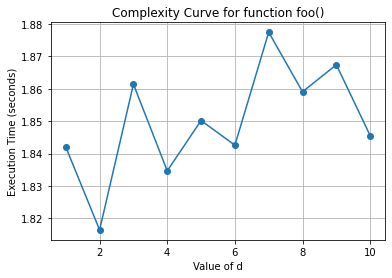

In [17]:
import timeit
import matplotlib.pyplot as plt

def foo(d):
    bp = BranchingProcess(d = d)
    bp.sample_psi()
    pass

# Define a range of values for parameter d
d_values = range(1, 11)  # Example: from 1 to 10

# Measure the execution time for each value of d
execution_times = []
for d in d_values:
    time_taken = timeit.timeit(lambda: foo(d), number = 1)
    execution_times.append(time_taken)

# Plot the curve of execution time against d
plt.plot(d_values, execution_times, marker='o')
plt.xlabel('Value of d')
plt.ylabel('Execution Time (seconds)')
plt.title('Complexity Curve for function foo()')
plt.grid(True)
plt.show()

